# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display

PATH = os.path.abspath('..')
sys.path.append(f'{PATH}/src')
from multiclass import *

# Data (mini training set)

In [2]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv, index_col=0)

display(df.sample(5, random_state=256))

,oh_p50
objID,
1237662302449500701,8.952116
1237665024905248887,8.724266
1237671939798073517,8.959539
1237662640658121002,8.992033
1237657611805196484,8.326750


In [3]:
# test-train split
n = len(df)
val_idxs = get_cv_idxs(n, val_pct=0.2, seed=256)

# Resnet training

In [23]:
arch = resnet18
sz = 128
bs = 8

# get data transformers and ClassifierData object (for regression)
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)

n_batch = len(data.trn_y) // bs

# initialize pretrained network
learn = ConvLearner.pretrained(arch, data, pretrained=True, precompute=True)
learn.crit = rmse

## Early layer (frozen) training

 75%|███████▌  | 30/40 [00:00<00:00, 70.29it/s, loss=102] 


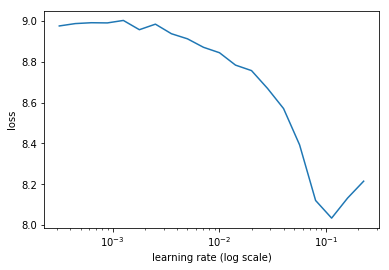

In [18]:
learn.lr_find()
learn.sched.plot()

In [24]:
learn.fit(3e-2, 1, cycle_len=50)

epoch      trn_loss   val_loss                            
    0      8.792387   8.650413  
    1      8.61083    8.275598                            
    2      7.265274   4.429045                            
    3      5.683144   3.393875                            
    4      4.225594   1.683749                            
    5      3.075983   1.114333                            
    6      2.114601   0.600203                            
    7      1.4806     0.389926                            
    8      0.977637   0.35386                              
    9      0.72835    0.263524                             
    10     0.577959   0.400986                             
    11     0.4493     0.313233                             
    12     0.374056   0.217755                             
    13     0.346624   0.222066                             
    14     0.301612   0.23539                              
    15     0.261412   0.20052                              
    16     0.24

[array([0.20329])]

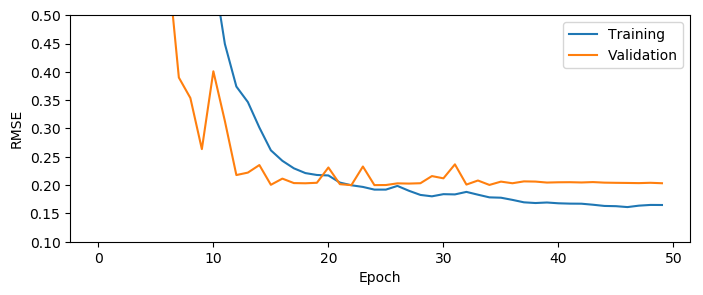

In [25]:
plt.figure(figsize=(8, 3), dpi=100)
plt.plot(learn.sched.losses[n_batch-1::n_batch], label='Training')
plt.plot(learn.sched.val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.ylim(0.1, 0.5)
plt.legend()

## Fine-tuning with unfrozen layers (not needed)

In [28]:
learn.unfreeze()

In [29]:
lrs = [1e-3, 3e-3, 1e-2]

learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                             
    0      0.18755    0.192663  
    1      0.178909   0.194386                             
    2      0.175026   0.183869                             
    3      0.177153   0.185329                             
    4      0.173564   0.179534                             
    5      0.168751   0.179205                             
    6      0.164965   0.178553                             



[array([0.17855])]

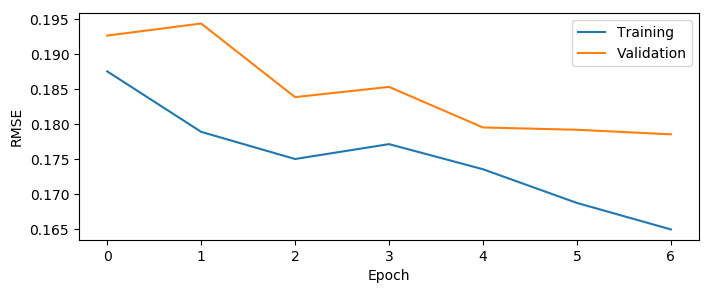

In [30]:
plt.figure(figsize=(8, 3), dpi=100)
plt.plot(learn.sched.losses[n_batch-1::n_batch], label='Training')
plt.plot(learn.sched.val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

# Testing

In [31]:
test_names = np.array([os.path.split(fname)[1][:-4] for fname in data.test_ds.fnames], dtype=np.int64)
df_test = pd.read_csv(f'{PATH}/catalogs/test.csv', index_col=0)
Z_true = df_test.loc[test_names].values

In [32]:
Z_pred, _ = learn.TTA(is_test=True)
Z_pred = Z_pred.mean(axis=0)
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.150 dex                        


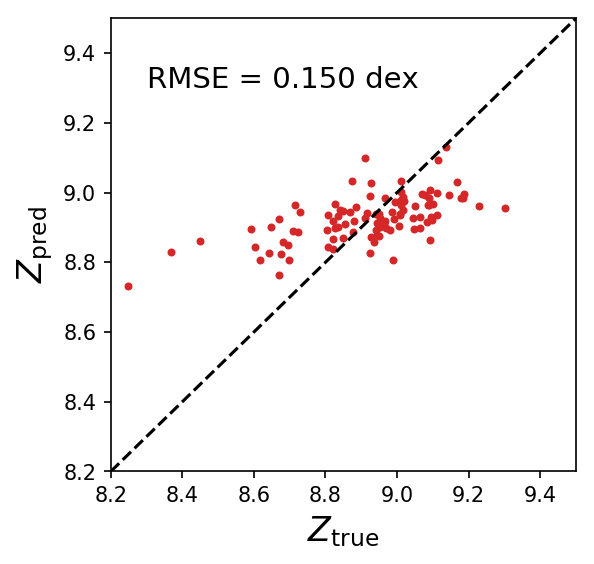

In [33]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.3, 9.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

# Compare with randomly re-oriented pixels (keep color the same)

In [ ]:
image = plt.imread(f'{PATH}/train/1237657119477334357.jpg')
plt.imshow(image)
plt.axis('off');

## Create function to shuffle around pixels while preserving color

In [ ]:
def shuffle_pixels(image, seed=None):
    """Given a N_k color image (with dimensions N_i x N_j), returns another 
    image that has the same pixel colors but shuffled pixel locations.
    
    Note that a random seed is optional since we may not want to have the
    pixels always randomly distributed in the same way.
    """
    
    N_i, N_j, N_k = image.shape
    if seed:
        np.random.seed(seed=seed)
    shuffled_raveled_image = np.random.permutation(image.reshape(-1, N_k))
    return shuffled_raveled_image.reshape((N_i, N_j, N_k))

In [ ]:
plt.imshow(shuffle_pixels(image))
plt.axis('off');

## Save pixel-shuffled test images

In [ ]:
for fname in tqdm_notebook(test_names):
    image = plt.imread(f'{PATH}/test/{fname}.jpg')
    plt.imsave(fname=f'{PATH}/test-shuffled/{fname}.jpg', arr=shuffle_pixels(image))

## Predict on shuffled test images

In [34]:
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-shuffled', num_workers=4)

learn.set_data(data)

In [35]:
Z_pred, _ = learn.TTA(is_test=True)
Z_pred = Z_pred.mean(axis=0)
print(f'Test RMSE = {rmse_np(Z_true, Z_pred):.3f} dex')

Test RMSE = 0.183 dex                        


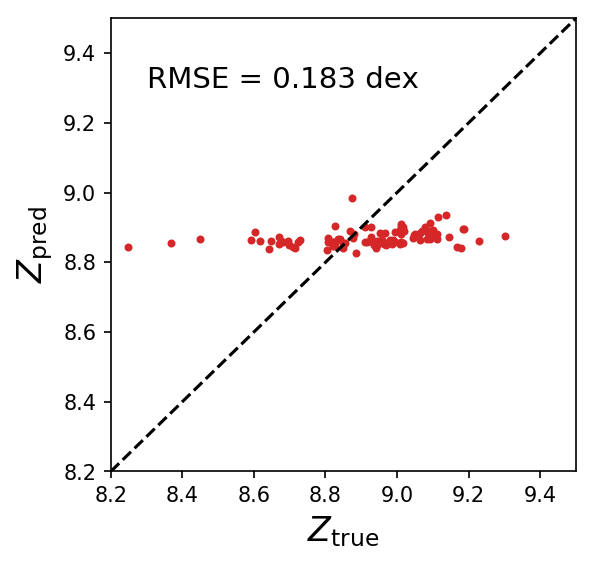

In [36]:
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(Z_true.flatten(), Z_pred.flatten(), s=8, c='C3')

ax.set_xlim(8.2, 9.5)
ax.set_ylim(8.2, 9.5)

ax.set_xlabel(r'$Z_{\rm true}$', fontsize=16)
ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=16)

ax.text(8.3, 9.3, f'RMSE = {rmse_np(Z_true, Z_pred):.3f} dex', fontsize=14)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k');

In [41]:
print(f'The RMSE around the mean of the test set is {rmse_np(Z_true.mean(), Z_true):.3f}.')

The RMSE around the mean of the test set is 0.182.


# Use less color information (*TBD*)

# Initial conclusions:
* Optimized training on tiny data set can yield ~ 0.15 dex predictions
* Scrambling pixels around (but preserving colors) basically results in a ~ 0.18 dex "prediction" which is effictively the same as predicting the mean all the time.